In [46]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
import scipy.ndimage

In [47]:
'''Data was the same data that was used for the notMNIST lesson'''

labels = np.load("../data/notMNIST/train_labels.npy")
train_images = np.load("../data/notMNIST/train_images.npy")
test_images = np.load("../data/notMNIST/test_images.npy")
label_names = np.array(['A','B','C','D','E','F','G','H','I','J'])

In [48]:
print("There are "+str(train_images.shape[0]) + " images in the dataset")
print("The dimensions of each image are "+str(train_images.shape[1])+" by "+ str(train_images.shape[2]))
print(test_images.shape)

There are 100 images in the dataset
The dimensions of each image are 28 by 28
(100, 28, 28)


In [49]:
def get_image_and_label(image_number):
    plt.matshow(train_images[image_number], cmap=plt.cm.gray)
    print(label_names[labels[image_number]])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)

In [50]:
'''
This code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. 


print("Origional image")
show_image(train_images[0])
print("Downscaled by 1/2")
show_image(scipy.ndimage.zoom(train_images[0],.5))
print("Upscaled back to origional")
show_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))
'''

'\nThis code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. \n\n\nprint("Origional image")\nshow_image(train_images[0])\nprint("Downscaled by 1/2")\nshow_image(scipy.ndimage.zoom(train_images[0],.5))\nprint("Upscaled back to origional")\nshow_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))\n'

In [51]:
'''This code creates downscaled datasets that can be used for training. 

'''
downscaled_train = np.array([scipy.ndimage.zoom(i,.5) for i in train_images])
downscaled_test = np.array([scipy.ndimage.zoom(i,.5) for i in test_images])
print(downscaled_train.shape)
print(train_images.shape)

(100, 14, 14)
(100, 28, 28)


In [60]:
'''
Model 1

Uses single layer NN. No convolution. 
'''

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))

multiplied = tf.matmul(small_train_flattened,w)+b

MSE = tf.reduce_mean(tf.square(multiplied - large_train_flattened))

pred = tf.reshape(multiplied,[-1,28,28])

optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [61]:
sess = tf.Session()
sess.run(init)

In [62]:
MAXSTEPS = 10000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 29.556646  Test MSE = 29.028425 
step = 1000  MSE = 1.591882   Test MSE = 4.841752  
step = 2000  MSE = 0.444995   Test MSE = 3.493284  
step = 3000  MSE = 0.165968   Test MSE = 2.965302  
step = 4000  MSE = 0.067775   Test MSE = 2.686441  
step = 5000  MSE = 0.027963   Test MSE = 2.522107  
step = 6000  MSE = 0.011076   Test MSE = 2.423828  
step = 7000  MSE = 0.004032   Test MSE = 2.369626  
step = 8000  MSE = 0.001316   Test MSE = 2.344192  
step = 9000  MSE = 0.000399   Test MSE = 2.334643  
Done!


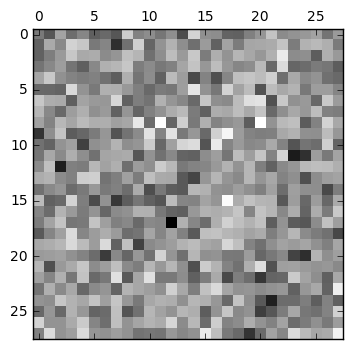

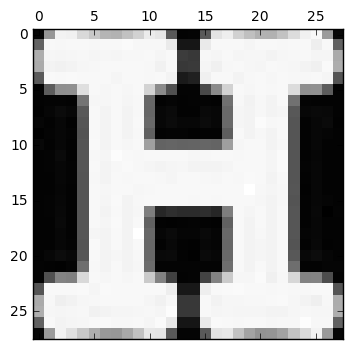

In [59]:
'''
Example of how terribly overfitted the model is at this point


'''

test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
show_image(test_pred[3])
show_image(train_pred[3])